C:\Users\WEW\AppData\Local\Programs\anaconda3\envs\my_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - Precision: 0.6855 - Recall: 0.6713 - accuracy: 0.6860 - loss: 0.6091 - val_Precision: 0.8111 - val_Recall: 0.7245 - val_accuracy: 0.7642 - val_loss: 0.5068 - learning_rate: 0.0010
Epoch 2/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Precision: 0.7369 - Recall: 0.7345 - accuracy: 0.7406 - loss: 0.5237 - val_Precision: 0.8178 - val_Recall: 0.7163 - val_accuracy: 0.7647 - val_loss: 0.4874 - learning_rate: 0.0010
Epoch 3/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Precision: 0.7415 - Recall: 0.7261 - accuracy: 0.7400 - loss: 0.5191 - val_Precision: 0.8101 - val_Recall: 0.7303 - val_accuracy: 0.7660 - val_loss: 0.4840 - learning_rate: 0.0010
Epoch 4/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Precision: 0.7429 - Recall: 0.7260 - accuracy: 0.7419 - loss: 0.5162 - val_Precision: 0.7993 - val_Recall: 0.7697 - val_accuracy: 0.7752 - val_loss: 0.4796 - learning_rate: 0.0010
Epoch 5/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Preci

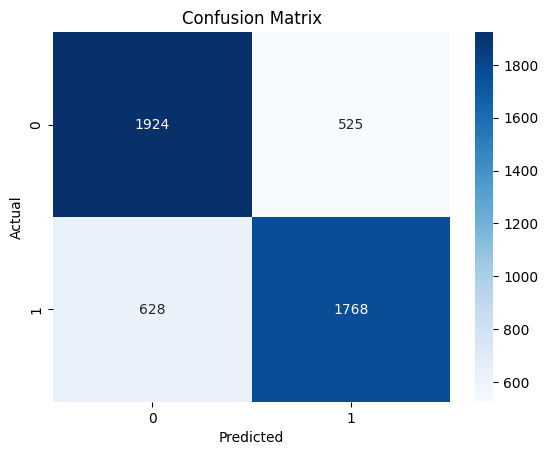

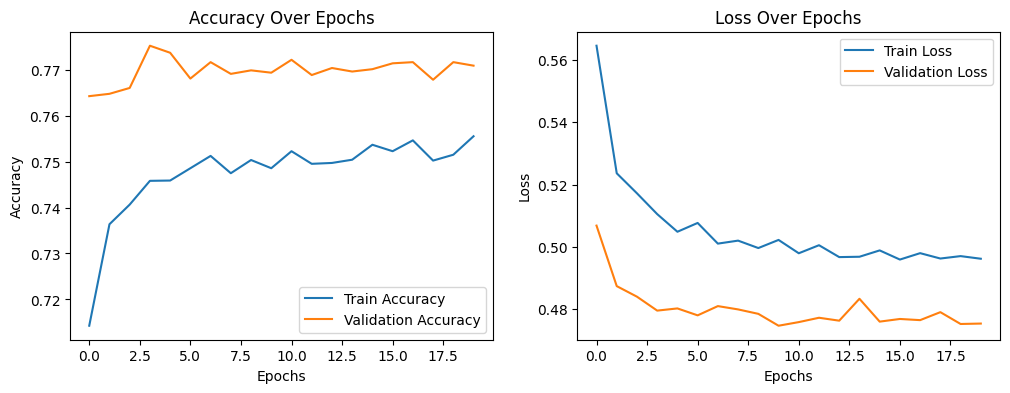

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib 

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE  # For handling class imbalance

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

#Set random seed for reproducibility
np.random.seed(42)

#Load data
data = pd.read_csv("match_data_v5.csv")

#Name columns
data.columns = ["matchID", "blueTeamControlWardsPlaced", "blueTeamWardsPlaced", "blueTeamTotalKills", 
                "blueTeamDragonKills", "blueTeamHeraldKills", "blueTeamTowersDestroyed", 
                "blueTeamInhibitorsDestroyed", "blueTeamTurretPlatesDestroyed", "blueTeamFirstBlood", 
                "blueTeamMinionsKilled", "blueTeamJungleMinions", "blueTeamTotalGold", "blueTeamXp", 
                "blueTeamTotalDamageToChamps", "redTeamControlWardsPlaced", "redTeamWardsPlaced", 
                "redTeamTotalKills", "redTeamDragonKills", "redTeamHeraldKills", "redTeamTowersDestroyed", 
                "redTeamInhibitorsDestroyed", "redTeamTurretPlatesDestroyed", "redTeamMinionsKilled", 
                "redTeamJungleMinions", "redTeamTotalGold", "redTeamXp", "redTeamTotalDamageToChamps", 
                "blueWin", "empty"]

#Drop unnecessary columns
data = data.drop(columns=['matchID', 'empty'])

#Handle missing values
data = data.dropna()

#Feature Engineering
data['totalKills'] = data['blueTeamTotalKills'] + data['redTeamTotalKills']
data['goldDiff'] = data['blueTeamTotalGold'] - data['redTeamTotalGold']
data['xpDiff'] = data['blueTeamXp'] - data['redTeamXp']
data['dragonDiff'] = data['blueTeamDragonKills'] - data['redTeamDragonKills']
data['heraldDiff'] = data['blueTeamHeraldKills'] - data['redTeamHeraldKills']
data['towerDiff'] = data['blueTeamTowersDestroyed'] - data['redTeamTowersDestroyed']
data['inhibitorDiff'] = data['blueTeamInhibitorsDestroyed'] - data['redTeamInhibitorsDestroyed']
data['turretPlateDiff'] = data['blueTeamTurretPlatesDestroyed'] - data['redTeamTurretPlatesDestroyed']
data['minionDiff'] = data['blueTeamMinionsKilled'] - data['redTeamMinionsKilled']
data['jungleMinionDiff'] = data['blueTeamJungleMinions'] - data['redTeamJungleMinions']
data['damageDiff'] = data['blueTeamTotalDamageToChamps'] - data['redTeamTotalDamageToChamps']
data['firstBlood'] = data['blueTeamFirstBlood'].astype(int)

#Select relevant features
features = ['goldDiff', 'xpDiff', 'dragonDiff', 'heraldDiff', 'towerDiff',
            'inhibitorDiff', 'turretPlateDiff', 'minionDiff', 'jungleMinionDiff',
            'damageDiff', 'firstBlood']

X = data[features]
y = data['blueWin'].astype(int)

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

#Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

#Save the scaler
joblib.dump(scaler, 'scaler.pkl')

#Define model architecture
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

#Compile model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

#Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

#Train model
history = model.fit(
    X_train_scaled,
    y_train_resampled,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

#Load the best model
model.load_weights('best_model.keras')

#Predict on test data
y_pred_probs = model.predict(X_test_scaled)
y_pred = (y_pred_probs > 0.5).astype(int)

#Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_probs)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")
print(f"Test ROC-AUC Score: {roc_auc:.4f}")

#Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#Plot training history
plt.figure(figsize=(12, 4))

#Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

#Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
